# **Implementing a Cosine Scheduler**

In [ ]:
#import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'

In [1]:
import timm, torch, random, datasets, math, fastcore.all as fc
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt
import k_diffusion as K, torchvision.transforms as T
import torchvision.transforms.functional as TF,torch.nn.functional as F

from torch.utils.data import DataLoader,default_collate
from pathlib import Path
from torch.nn import init
from fastcore.foundation import L
from torch import nn,tensor
from datasets import load_dataset
from operator import itemgetter
from torcheval.metrics import MulticlassAccuracy
from functools import partial
from torch.optim import lr_scheduler
from torch import optim

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from fastprogress import progress_bar
from diffusers import UNet2DModel, DDIMPipeline, DDPMPipeline, DDIMScheduler, DDPMScheduler

In [3]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl, yl = 'image', 'label'
name = "fashion_mnist"
bs = 512
dsd = load_dataset(name)

By this point in early 2023, the research community had started to develop a sense for what worked and what didn't wrt Stable Diffusion 1.0. Within a few months of its release, significant improvements had already been made to the overall readability of the code, simplifications to the math functions, in addition to swapping out or dropping unnecessary code blocks.

Also, this NB highlights the need to sometimes step back and reframe some of the key steps in modelling processes. For example, we will be replacing discrete timesteps with continuous ones resulting in improved sampling while also simplifying the notations.

In [40]:
# We will get rid of T in the abar function, the assumption here is the timestep is now continuous instead of discrete
# and falls between 0 and 1. With 1 being pure noise.
def abar(t): return (t*math.pi/2).cos()**2
def inv_abar(x): return x.sqrt().acos()*2/math.pi

In [41]:
def noisify(x0):
    device = x0.device
    n = len(x0)
    t = torch.rand(n,).to(x0).clamp(0, 0.999) # clamping due to continuous t
    ε = torch.randn(x0.shape, device=device)
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    xt = abar_t.sqrt()*x0 + (1-abar_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [7]:
def collate_ddpm(b): return noisify(default_collate(b)[xl])
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=6)

In [8]:
@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

dl = dls.train
(xt, t), eps = next(iter(dl))

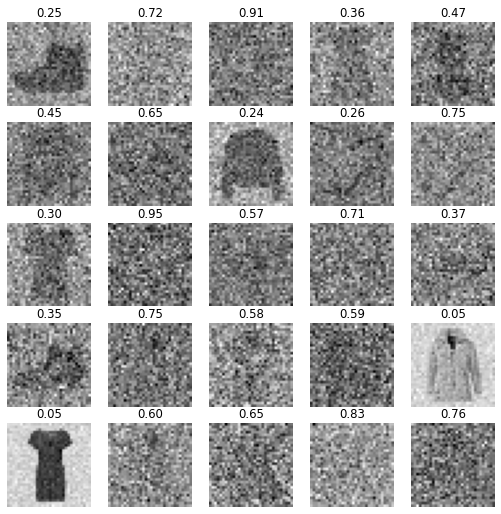

In [9]:
show_images(xt[:25], imsize=1.8, titles=fc.map_ex(t[:25], '{:.02f}'))

Given the changes to how the timesteps are being handled, we can now sample and plot items based on the how far along they are in the forward diffusion process. So the dress sample in the bottom left of the grid is **5%** in its forward diffusion process, and the item in the bottom right is **76%**, which is much closer to pure noise.

In [13]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [14]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [15]:
lr = 4e-3
epochs = 25
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.397,0,train
0.076,0,eval
0.059,1,train
0.050,1,eval
0.049,2,train
0.050,2,eval
0.047,3,train
0.043,3,eval
0.044,4,train
0.051,4,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


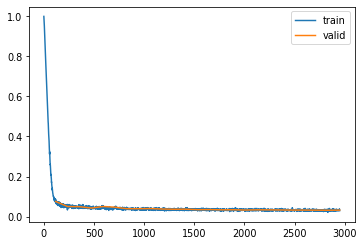

In [17]:
learn.fit(epochs)

In [16]:
# Save model
#torch.save(learn.model, 'models/fashion_cos.pkl')
model = learn.model = torch.load('models/fashion_cos.pkl').cuda()

In [42]:
# Thanks to the changes made to the handling of timesteps, we can take a batch of data and denoise it
# Remember, t is different for each item in the batch.
def denoise(x_t, noise, t):
    device = x_t.device
    abar_t = abar(t).reshape(-1, 1, 1, 1).to(device)
    return ((x_t - (1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-1, 1)

In [18]:
with torch.no_grad():noise = learn.model((xt.cuda(), t.cuda()))

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


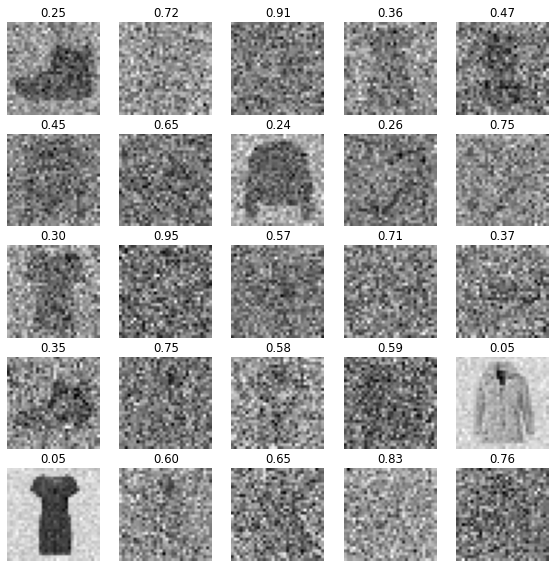

In [19]:
show_images(xt[:25], imsize=2, titles=fc.map_ex(t[:25], '{:0.02f}'))

The tiny changes introduced in this NB allow us to plot each batch item along with its progress with respect to the forward diffusion process.
Using `denoise()` allows us to see the quality of the generated outputs with noise removed after a single inference step. 

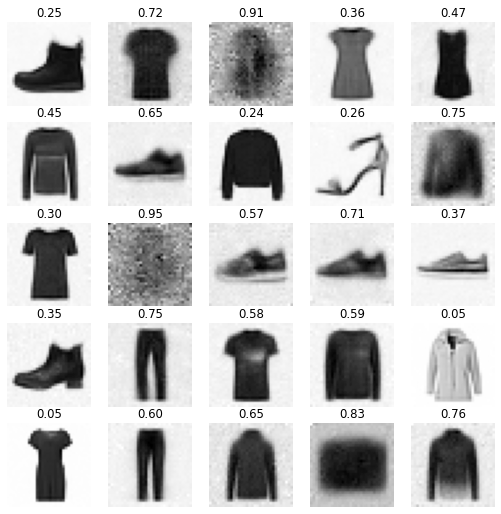

In [22]:
show_images(denoise(xt.cuda(), noise, t.cuda())[:25].clamp(-1, 1), 
            imsize=1.8, titles=fc.map_ex(t[:25], '{:.02f}'))

## **Sampling**

In [23]:
from miniai.fid import ImageEval

In [33]:
cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

bs = 2048
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

dt = dls.train
xb, yb = next(iter(dt))

ie = ImageEval(cmodel, dls, cbs=[DeviceCB()])

In [34]:
sz = (2048, 1, 32, 32)

In [26]:
def ddim_step(x_t, noise, abar_t, abar_t1, bbar_t, bbar_t1, eta, sig):
    sig = ((bbar_t1/bbar_t).sqrt() * (1-abar_t/abar_t1).sqrt()) * eta
    x_0_hat = ((x_t-(1-abar_t).sqrt()*noise) / abar_t.sqrt()).clamp(-1.5, 1.5)
    if bbar_t1 <= sig**2+0.01: sig = 0. # Zero if bbar is very small or NaN
    x_t = abar_t1.sqrt()*x_0_hat + (bbar_t1-sig**2).sqrt()*noise
    x_t += sig * torch.randn(x_t.shape).to(x_t)
    return x_0_hat, x_t

In [43]:
@torch.no_grad()
def sample(f, model, sz, steps, eta=1.):
    # Instead of range(), we will use linspace() to create our timesteps
    ts = torch.linspace(1-1/steps, 0, steps) # convert discrete steps to val between 0 and .999
    x_t = torch.randn(sz).to(model.device)
    preds = []
    for i, t in enumerate(progress_bar(ts)):
        abar_t = abar(t)
        noise = model((x_t, t))
        abar_t1 = abar(t-1/steps) if t >= 1/steps else torch.tensor(1) # Again, convert discrete steps to continuous
        x_0_hat, x_t = f(x_t, noise, abar_t, abar_t1, 1-abar_t, 1-abar_t1, eta, 1-((i+1)/100))
        preds.append(x_0_hat.float().cpu())
    return preds

In [35]:
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
s = (preds[-1]*2)
s.min(), s.max(), s.shape

(tensor(-1.1377), tensor(1.5152), torch.Size([2048, 1, 32, 32]))

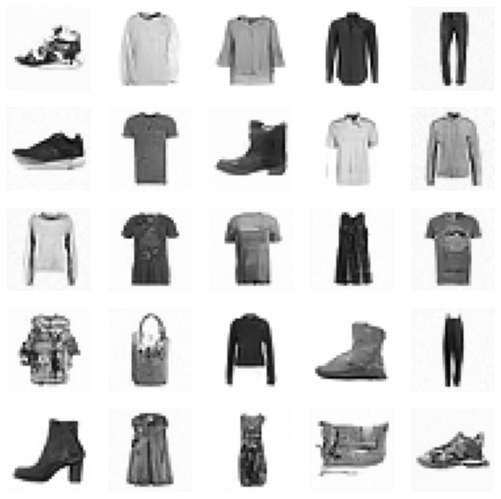

In [36]:
show_images(s[:25], imsize=1.8)

In [37]:
ie.fid(s), ie.kid(s), s.shape

(4.1805419921875, 0.00338254333473742, torch.Size([2048, 1, 32, 32]))

In [38]:
preds = sample(ddim_step, model, sz, steps=100, eta=1.)
ie.fid(preds[-1]*2)

3.58251953125

In [39]:
preds = sample(ddim_step, model, sz, steps=50, eta=1.)
ie.fid(preds[-1]*2)

5.6156005859375